In [16]:
import pickle
import os
import sys
from pathlib import Path
import logging
import pandas as pd
import os
import nibabel as nib
import matplotlib.pyplot as plt
import torch
import SimpleITK as sitk
import json
import pandas as pd
import numpy as np
import cc3d
import csv
from scipy.stats import gaussian_kde

## Make and save dicts with number of connected components and their size for each image

In [2]:
def nii2numpy(nii_path):
    # input: path of NIfTI segmentation file, output: corresponding numpy array and voxel_vol in ml
    mask_nii = nib.load(str(nii_path))
    mask = mask_nii.get_fdata()
    pixdim = mask_nii.header['pixdim']   
    voxel_vol = pixdim[1]*pixdim[2]*pixdim[3]/1000
    return mask, voxel_vol


def con_comp(seg_array):
    # input: a binary segmentation array output: an array with seperated (indexed) connected components of the segmentation array
    connectivity = 18
    conn_comp = cc3d.connected_components(seg_array, connectivity=connectivity)
    return conn_comp

In [3]:
labels_tr_folder = 'nnUnet_raw/Dataset219_PETCT/labelsTr'
#CV_preds_folder = 'nnUNet_results/Dataset219_PETCT/nnUNetTrainer__nnUNetPlans__3d_fullres/crossval_results_folds_0_1_2_3_4'

CV_preds_folder = "nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs_NoMirroring__nnUNetPlans__3d_fullres/crossval_results_folds_0_1_2_3_4"

labels = os.listdir(labels_tr_folder)

CV_preds = [x for x in os.listdir(CV_preds_folder) if 'nii.gz' in x]

In [4]:
def make_conn_comp_dict(labels,folder):
#look at how big each connected component is in all the GT images
    dict_of_images = {}
    for label in labels:
        gt_mask,voxel_vol = nii2numpy(os.path.join(folder,label))
        conn_comp_array = con_comp(gt_mask)

        unique_elements, counts = np.unique(conn_comp_array, return_counts=True)

        indiv_dict = {}

        # Print the results
        for element, count in zip(unique_elements, counts):
            indiv_dict[int(element)]=int(count)

        dict_of_images[label] = indiv_dict
    
    return dict_of_images

In [5]:
dict_of_images = make_conn_comp_dict(labels,labels_tr_folder)
with open("GT_conn_comps.json", "w") as outfile:
    json.dump(dict_of_images, outfile)

KeyboardInterrupt: 

In [ ]:
dict_of_images_preds = make_conn_comp_dict(CV_preds,CV_preds_folder)

with open("a_CV_preds_conn_comps.json", "w") as outfile:
    json.dump(dict_of_images_preds, outfile)
    

In [9]:
f = open('a_CV_preds_conn_comps.json')
f_gt = open("GT_conn_comps.json")
dict_of_images_preds = json.load(f)
dict_of_images = json.load(f_gt)

In [10]:
# create final dict with predictions for positive images
pos_dict_of_images_preds = {}

for key in dict_of_images:
    if len(dict_of_images[key]) != 1:
        pos_dict_of_images_preds[key] = dict_of_images_preds[key]

## Analyse connected components

In [11]:
fg_counts_gt = []
for key in dict_of_images.keys():
    fg_counts_gt.append(list(dict_of_images[key].values())[1:]) #only take foreground counts (not 0 for background)

fg_counts_preds = []
for key in dict_of_images_preds.keys():
    fg_counts_preds.append(list(dict_of_images_preds[key].values())[1:]) #only take foreground counts (not 0 for background)
    
fg_counts_pos_preds = []
for key in pos_dict_of_images_preds.keys():
    fg_counts_pos_preds.append(list(pos_dict_of_images_preds[key].values())[1:]) #only take foreground counts (not 0 for background)


### Count median number of components

In [30]:
import numpy as np
def count_comps(fg_list):
    # make list of num of connected comps per image
    num_comps = []
    for sublist in fg_list:
        num_comps.append(len(sublist))

    # remove lists which are true negative images
    non_zero = []
    zeros = 0
    for item in num_comps:
        if item != 0:
            non_zero.append(item)
        else:
            zeros += 1
    
    # number of negative images
    print(f"Number of negative images: {zeros}/{len(num_comps)}")

    # median number of conn comps in pos images
    print(f"Median number of conn comps in pos images: {np.median(non_zero)}")
      
    # mean number of conn comps
    print(f"Mean number of conn comps in pos images: {np.mean(non_zero)}")
    
    return num_comps

In [31]:
# ground truth
num_comps_gt = count_comps(fg_counts_gt)

Number of negative images: 468/919
Median number of conn comps in pos images: 6.0
Mean number of conn comps in pos images: 17.059866962305986


In [32]:
# CV val predictions
num_comps_preds = count_comps(fg_counts_preds)

Number of negative images: 125/919
Median number of conn comps in pos images: 5.0
Mean number of conn comps in pos images: 10.210327455919396


In [33]:
# CV val predictions on positive imgaes
num_comps_pos_preds = count_comps(fg_counts_pos_preds)

Number of negative images: 3/451
Median number of conn comps in pos images: 8.0
Mean number of conn comps in pos images: 15.138392857142858


(0.0, 100.0)

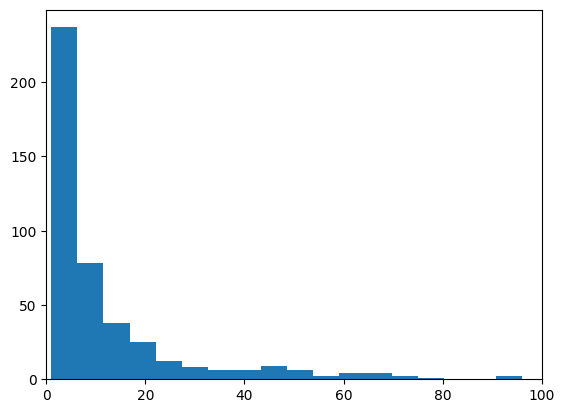

In [89]:
# distribution of number of conn comps in GT labels (when non-0)
plt.hist([x for x in num_comps_gt if x != 0],bins=200)
plt.xlim([0,100])

(0.0, 100.0)

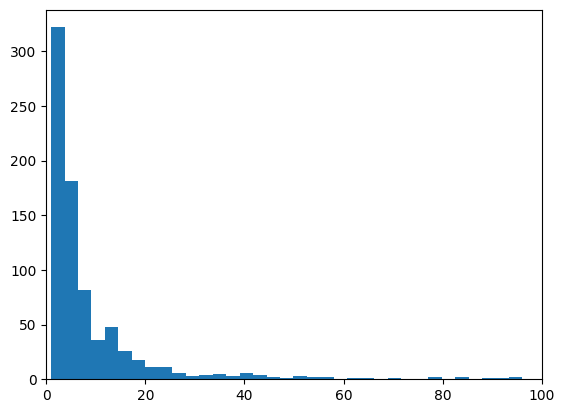

In [87]:
plt.hist([x for x in num_comps_preds if x != 0],bins=200)
plt.xlim([0,100])

(0.0, 100.0)

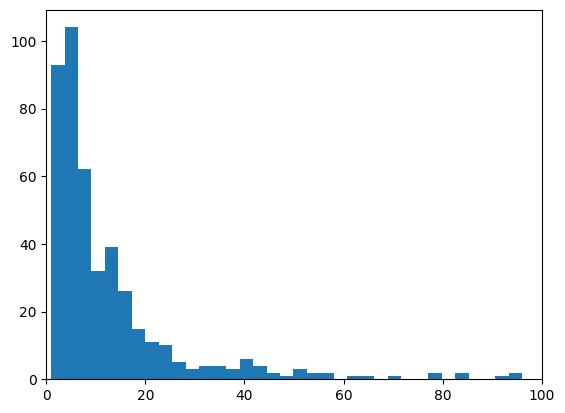

In [88]:
plt.hist([x for x in num_comps_pos_preds if x != 0],bins=200)
plt.xlim([0,100])

### Count median size of components

In [38]:
def count_sizes(fg_counts):
    mean_sizes = []
    median_sizes = []
    for image in fg_counts:
        if len(image) != 0:
            mean_sizes.append(np.mean(image))
            median_sizes.append(np.median(image))

    print(f"Median number of mean size of conn comps in pos images: {np.median(mean_sizes)}")
    print(f"Median number of median size of conn comps in pos images: {np.median(median_sizes)}")
    
    return median_sizes

In [39]:
median_sizes_gt = count_sizes(fg_counts_gt)

Median number of mean size of conn comps in pos images: 935.8571428571429
Median number of median size of conn comps in pos images: 183.0


In [40]:
median_sizes_preds = count_sizes(fg_counts_preds)

Median number of mean size of conn comps in pos images: 231.54761904761904
Median number of median size of conn comps in pos images: 59.25


In [41]:
median_sizes_preds_pos = count_sizes(fg_counts_pos_preds)

Median number of mean size of conn comps in pos images: 763.7
Median number of median size of conn comps in pos images: 91.0


(0.0, 5000.0)

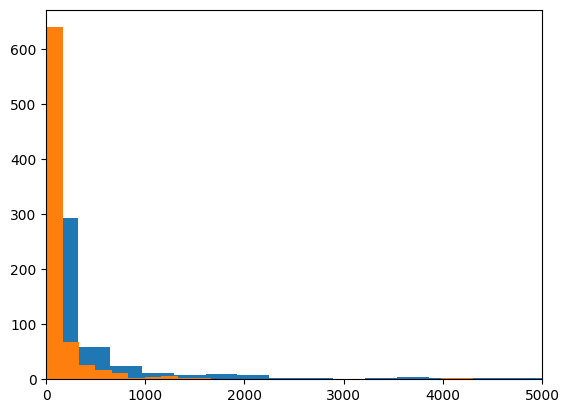

In [42]:
plt.hist(median_sizes_gt,bins=100)
plt.hist(median_sizes_preds,bins=100)

plt.xlim([0,5000])

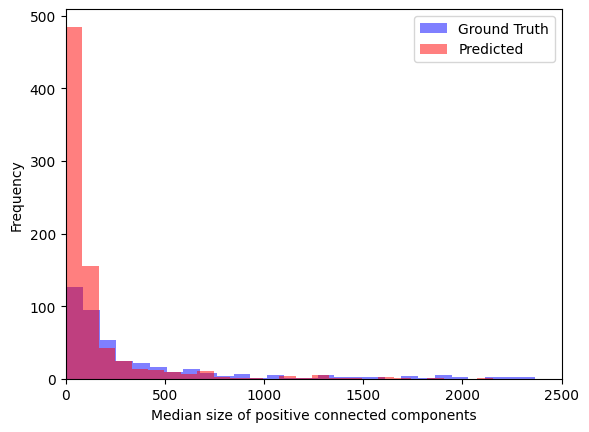

In [54]:
plt.hist(median_sizes_gt, bins=380, alpha=0.5, label='Ground Truth', color='blue')

plt.hist(median_sizes_preds, bins=200, alpha=0.5, label='Predicted', color='red')

plt.xlim([0, 2500])
plt.xlabel('Median size of positive connected components')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [49]:
plt.hist(mean_sizes_gt, bins=400, alpha=0.5, label='Ground Truth', color='blue')

# Create a histogram for predicted data
plt.hist(mean_sizes_preds, bins=200, alpha=0.5, label='Predicted', color='red')

# Set the x-axis limits
plt.xlim([0, 2500])

# Add labels and a legend
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.legend()

# Add a title
plt.title('Size Distribution Comparison')

# Show the plot
plt.show()


NameError: name 'mean_sizes_gt' is not defined

(0.0, 5000.0)

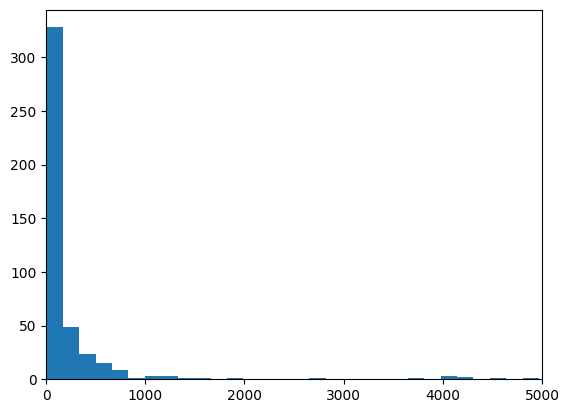

In [116]:
plt.hist(median_sizes_preds_pos,bins=100)
plt.xlim([0,5000])

### Look at distribution of component size

In [149]:
def plot_size_dist(fg_list):
    flattened_list = [item for sublist in fg_list for item in sublist]
    
    #plt.hist(flattened_list,bins=100)
    plt.hist([x for x in flattened_list if x < 100],bins=20)

    plt.xlabel('Conn component size')


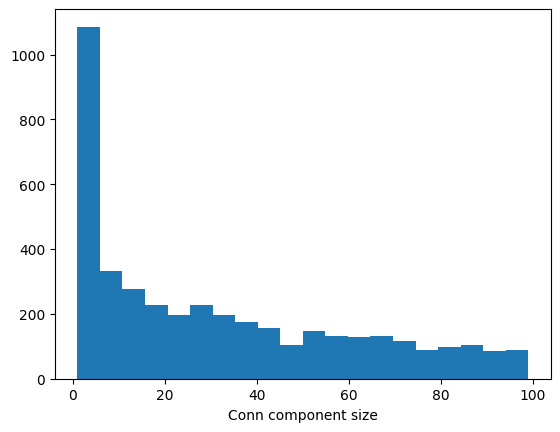

In [150]:
plot_size_dist(fg_counts_gt)

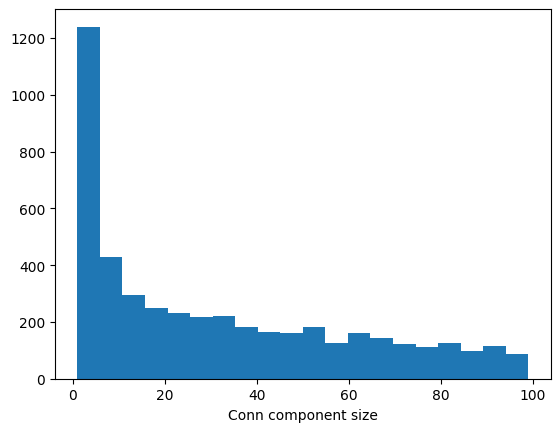

In [151]:
plot_size_dist(fg_counts_preds)

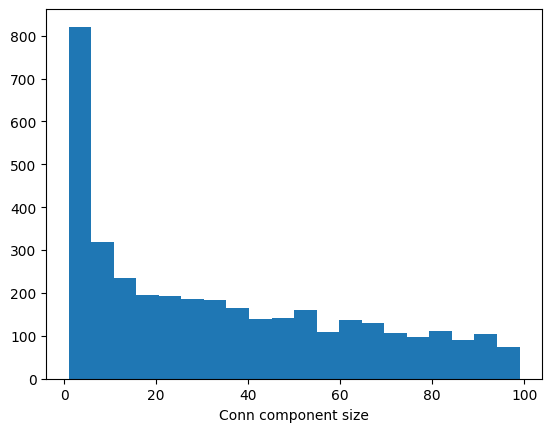

In [152]:
plot_size_dist(fg_counts_pos_preds)

## Analyse effect of removal of different sized connected components

In [3]:
from datetime import datetime

clinical_data_df = pd.read_csv('Clinical Metadata FDG PET_CT Lesions (1).csv')
#clinical_data_df['Study Date'] = clinical_data_df['Study Date'].apply(lambda x: x.replace("/", ""))

# add zeros to date so it is compatible w/ other data
clinical_data_df['Study Date'] = clinical_data_df['Study Date'].apply(lambda x: (datetime.strptime(x, "%m/%d/%Y")).strftime("%m%d%Y"))
def load_process_inf_metrics(input_df):
    f_metrics_df = pd.read_csv(input_df)
    f_metrics_df['subject_id'] = f_metrics_df['image'].apply(lambda x: x.split('_')[0]+"_"+x.split('_')[1])
    f_metrics_df['subject_date'] = f_metrics_df['image'].apply(lambda x: x.split('_')[2].split(".")[0])
    
    f_metrics_df = f_metrics_df.drop(columns=['Unnamed: 0'])
    
    # Merge the two DataFrames based on 'subject_id' and 'subject_date'
    merged_df = f_metrics_df.merge(clinical_data_df, left_on=['subject_id', 'subject_date'], right_on=['Subject ID', 'Study Date'], how='left')

    # Drop the duplicate columns 'Subject ID' and 'Study Date' (optional, if you want to keep only one set of them)
    merged_df.drop(columns=['Subject ID', 'Study Date'], inplace=True)

    # Rename the 'Diagnosis' column to 'diagnosis' (optional, if you want to match the column name)
    merged_df.rename(columns={'Diagnosis': 'diagnosis'}, inplace=True)
    
    merged_df = merged_df[merged_df['Modality']=='SEG']
    
    return merged_df

In [4]:
list_csvs = ['a_219_inf_results.csv','5_pp_metrics_df','10_pp_metrics_df','20_pp_metrics_df','40_pp_metrics_df','80_pp_metrics_df']
list_pp_sizes = [0,5,10,20,40,80]

list_dfs = []
for csv in list_csvs:
    list_dfs.append(load_process_inf_metrics(csv))


In [9]:
list_dfs[0]

,image,DICE,challenge_FP,challenge_FN,subject_id,subject_date,Series UID,Collection,3rd Party Analysis,Data Description URI,...,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp,diagnosis,age,sex
0,PETCT_661ddc60e0_03082002.nii.gz,0.839286,0.000000,0.000000,PETCT_661ddc60e0,03082002,1.3.6.1.4.1.14519.5.2.1.4219.6651.329516157931...,FDG-PET-CT-Lesions,NO,NaN,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,5.88 MB,./FDG-PET-CT-Lesions/PETCT_661ddc60e0/03-08-20...,2022-03-17T16:04:14.333,MELANOMA,078Y,M
4,PETCT_f082a3d319_11082004.nii.gz,0.000000,0.136851,0.000000,PETCT_f082a3d319,11082004,1.3.6.1.4.1.14519.5.2.1.4219.6651.306359696386...,FDG-PET-CT-Lesions,NO,NaN,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,5.01 MB,./FDG-PET-CT-Lesions/PETCT_f082a3d319/11-08-20...,2022-03-17T21:19:53.125,NEGATIVE,044Y,M
7,PETCT_2922971d0f_07192003.nii.gz,0.000000,8.683833,0.000000,PETCT_2922971d0f,07192003,1.3.6.1.4.1.14519.5.2.1.4219.6651.168597161521...,FDG-PET-CT-Lesions,NO,NaN,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.75 MB,./FDG-PET-CT-Lesions/PETCT_2922971d0f/07-19-20...,2022-03-17T13:58:56.794,NEGATIVE,077Y,F
9,PETCT_ae8c77a995_05182007.nii.gz,0.479889,0.000000,3.222224,PETCT_ae8c77a995,05182007,1.3.6.1.4.1.14519.5.2.1.4219.6651.223200767263...,FDG-PET-CT-Lesions,NO,NaN,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.60 MB,./FDG-PET-CT-Lesions/PETCT_ae8c77a995/05-18-20...,2022-03-17T18:31:32.903,MELANOMA,050Y,F
12,PETCT_277fc3c67c_11152003.nii.gz,0.000000,21.585171,0.000000,PETCT_277fc3c67c,11152003,1.3.6.1.4.1.14519.5.2.1.4219.6651.197238272238...,FDG-PET-CT-Lesions,NO,NaN,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,5.88 MB,./FDG-PET-CT-Lesions/PETCT_277fc3c67c/11-15-20...,2022-03-17T13:55:42.07,NEGATIVE,073Y,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,PETCT_76ebd5c736_12292005.nii.gz,0.461538,0.111969,0.796225,PETCT_76ebd5c736,12292005,1.3.6.1.4.1.14519.5.2.1.4219.6651.134630856972...,FDG-PET-CT-Lesions,NO,NaN,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.60 MB,./FDG-PET-CT-Lesions/PETCT_76ebd5c736/12-29-20...,2022-03-17T16:27:04.01,MELANOMA,053Y,M
273,PETCT_a9d7a14ba1_08142000.nii.gz,0.557038,0.049764,0.049764,PETCT_a9d7a14ba1,08142000,1.3.6.1.4.1.14519.5.2.1.4219.6651.101931276996...,FDG-PET-CT-Lesions,NO,NaN,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,5.88 MB,./FDG-PET-CT-Lesions/PETCT_a9d7a14ba1/08-14-20...,2022-03-17T18:21:07.855,LUNG_CANCER,065Y,M
276,PETCT_89fb723947_09032000.nii.gz,0.869232,0.634492,0.000000,PETCT_89fb723947,09032000,1.3.6.1.4.1.14519.5.2.1.4219.6651.194801755496...,FDG-PET-CT-Lesions,NO,NaN,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.76 MB,./FDG-PET-CT-Lesions/PETCT_89fb723947/09-03-20...,2022-03-17T17:02:10.62,LUNG_CANCER,058Y,M
280,PETCT_ded50b1e68_02092006.nii.gz,NaN,0.000000,0.000000,PETCT_ded50b1e68,02092006,1.3.6.1.4.1.14519.5.2.1.4219.6651.294313739661...,FDG-PET-CT-Lesions,NO,NaN,...,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,6.13 MB,./FDG-PET-CT-Lesions/PETCT_ded50b1e68/02-09-20...,2022-03-17T20:44:06.955,NEGATIVE,060Y,M


In [21]:
CV_preds_folder = "nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs_NoMirroring__nnUNetPlans__3d_fullres/processedinferTs10"
for image in os.listdir(CV_preds_folder):
    a, vol =nii2numpy(os.path.join(CV_preds_folder,image))
    print(vol)

0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001
0.001


KeyboardInterrupt: 

In [18]:
# voxel vol = 0.001
# sohuld be:
labels_folder = '/gpfs3/well/papiez/users/hri611/python/nnUnet_raw/Dataset220_PETCT/labelsTs'
for image in os.listdir(labels_folder):
    a, vol =nii2numpy(os.path.join(labels_folder,image))
    print(vol)

0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.012441020965576172
0.01244102096

KeyboardInterrupt: 

In [23]:
coef = 0.012441020965576172/0.001
coef

12.441020965576172

In [7]:

def nii2numpy(nii_path):
    # input: path of NIfTI segmentation file, output: corresponding numpy array and voxel_vol in ml
    mask_nii = nib.load(str(nii_path))
    mask = mask_nii.get_fdata()
    pixdim = mask_nii.header['pixdim']   
    voxel_vol = pixdim[1]*pixdim[2]*pixdim[3]/1000
    return mask, voxel_vol


def con_comp(seg_array):
    # input: a binary segmentation array output: an array with seperated (indexed) connected components of the segmentation array
    connectivity = 18
    conn_comp = cc3d.connected_components(seg_array, connectivity=connectivity)
    return conn_comp


def false_pos_pix(gt_array,pred_array):
    # compute number of voxels of false positive connected components in prediction mask
    pred_conn_comp = con_comp(pred_array)
    
    false_pos = 0
    for idx in range(1,pred_conn_comp.max()+1):
        comp_mask = np.isin(pred_conn_comp, idx)
        if (comp_mask*gt_array).sum() == 0:
            false_pos = false_pos+comp_mask.sum()
    return false_pos



def false_neg_pix(gt_array,pred_array):
    # compute number of voxels of false negative connected components (of the ground truth mask) in the prediction mask
    gt_conn_comp = con_comp(gt_array)
    
    false_neg = 0
    for idx in range(1,gt_conn_comp.max()+1):
        comp_mask = np.isin(gt_conn_comp, idx)
        if (comp_mask*pred_array).sum() == 0:
            false_neg = false_neg+comp_mask.sum()
            
    return false_neg


def dice_score(mask1,mask2):
    # compute foreground Dice coefficient
    overlap = (mask1*mask2).sum()
    sum = mask1.sum()+mask2.sum()
    dice_score = 2*overlap/sum
    return dice_score


def compute_metrics(nii_gt_path, nii_pred_path):
    # main function
    gt_array, voxel_vol = nii2numpy(nii_gt_path)
    pred_array, voxel_vol = nii2numpy(nii_pred_path)

    false_neg_vol = false_neg_pix(gt_array, pred_array) *voxel_vol
    false_pos_vol = false_pos_pix(gt_array, pred_array) *voxel_vol
    dice_sc = dice_score(gt_array,pred_array)

    return dice_sc, false_pos_vol, false_neg_vol


Text(0, 0.5, 'DICE')

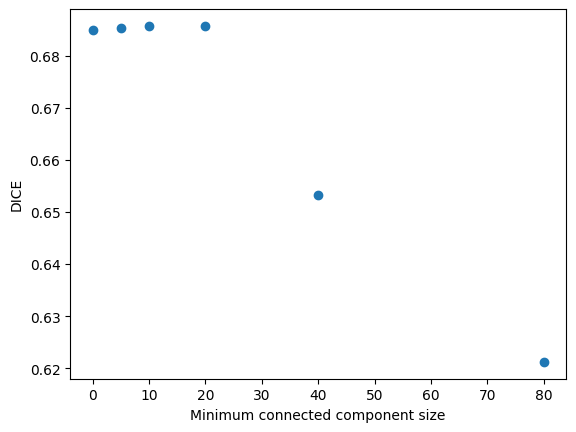

In [5]:
variable = 'DICE'

list_pos_dfs = [df[df['diagnosis']!='NEGATIVE'] for df in list_dfs]
plt.scatter(list_pp_sizes,[x[variable].mean() for x in list_pos_dfs])
#plt.scatter(list_pp_sizes,[x[variable].mean() for x in list_dfs])

plt.xlabel('Minimum connected component size')
plt.ylabel(variable)

In [24]:
summary_df = pd.DataFrame()
summary_df['Min_size']=list_pp_sizes
summary_df['Mean_dice']=[x['DICE'].mean() for x in list_pos_dfs]
summary_df['FP']=[x['challenge_FP'].mean() for x in list_dfs]
summary_df['FN']=[x['challenge_FN'].mean() for x in list_pos_dfs]


In [28]:
summary_df.to_csv('false_fpfn_pp.csv')

In [27]:
0.5*12.441020965576172

6.220510482788086

In [46]:
summary_df['Weighted_avg'] = -summary_df['Mean_dice']*1/2 + summary_df['FP']*1/4 + summary_df['FN']*1/4

In [ ]:
plt.scatter(list_pp_sizes,[x['DICE'].mean() for x in list_dfs])

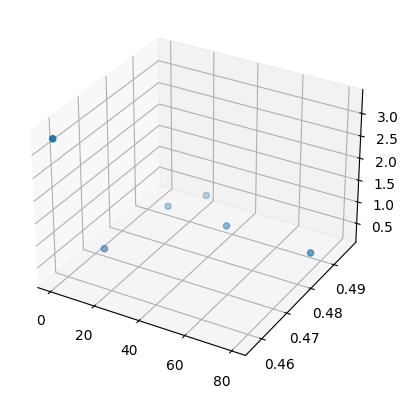

In [40]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(list_pp_sizes, [x['DICE'].mean() for x in list_dfs], [x['challenge_FN'].mean() for x in list_dfs])

In [30]:
list_pos_dfs[0]['challenge_FP'].mean()

0.28428000000000003

In [6]:
pp_df_10

,Unnamed: 0,image,DICE,challenge_FP,challenge_FN
0,0,PETCT_b1219c408b_10042002.nii.gz,0.743878,0.000,0.409
1,1,PETCT_ca89066e44_08112005.nii.gz,0.782298,0.000,0.002
2,2,PETCT_a3ce52b2a8_11152003.nii.gz,0.000000,0.203,0.000
3,3,PETCT_99e5728030_04182002.nii.gz,0.717888,3.024,0.297
4,4,PETCT_68ef307665_05162003.nii.gz,NaN,0.000,0.000
...,...,...,...,...,...
90,90,PETCT_68a7ade33c_07082001.nii.gz,0.876301,0.246,0.311
91,91,PETCT_a41d59682f_09292006.nii.gz,0.000000,4.154,0.000
92,92,PETCT_dc3437c9b9_11212002.nii.gz,NaN,0.000,0.000
93,93,PETCT_38733c001e_07282006.nii.gz,NaN,0.000,0.000


In [1]:
## NN UNet post processing

In [2]:
from batchgenerators.utilities.file_and_folder_operations import *

In [3]:
a = load_pickle('/gpfs3/well/papiez/users/hri611/python/nnUNet_results/Dataset219_PETCT/nnUNetTrainer_1500epochs__nnUNetPlans__3d_fullres/crossval_results_folds_0_1_2_3_4/postprocessing.pkl')



In [5]:
print(a)

([], [])
